## in this version several patches are covered but the approach is te same as v1.1

In [1]:
import fitsio, time, sys
import numpy as np
from mpmath import *
from concurrent.futures import ProcessPoolExecutor as Executor
sys.path.append("/home/joar/google-drive/PhD/NPCF/pyMethodsClasses/")
from QTrees import Point, Rect, QuadTree
from histoStuffs import *

In [17]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import ImageGrid

cmap=plt.get_cmap('RdBu')

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

norm = MidpointNormalize(midpoint=0)

In [18]:
file_name = '~/google-drive/PhD/NPCF/codes_npcf/treeCorr/convergence/data/Aardvark_cpy.fit'
data = fitsio.read(file_name)

In [4]:
dataConv=[]
for ii,jj,kk in zip(data["RA"],data["DEC"],data["KAPPA"]):
    dataConv.append(Point(ii,jj,payload=kk))

In [5]:
# for rectangle's domain 
minRA,maxRA=min(data["RA"]),max(data["RA"])
minDEC,maxDEC=min(data["DEC"]),max(data["DEC"])
domWidth=maxRA-minRA
domHeight=maxDEC-minDEC
cx=(maxRA+minRA)/2
cy=(maxDEC+minDEC)/2
# rectangle's domain
domain = Rect(cx, cy, domWidth, domHeight)
qtree = QuadTree(domain)
for point in dataConv:
    qtree.insert(point)

In [6]:
# for patches
NxPtchs=4
NxBndrs=NxPtchs+1
NyPtchs=NxPtchs
NyBndrs=NxBndrs
xdivsns=np.linspace(minRA,maxRA,NxBndrs)
ydivsns=np.linspace(minDEC,maxDEC,NyBndrs)
# regions
regions=[]
for row in range(NyPtchs):
    for nn in range(NxPtchs):
        regions.append(Rect((xdivsns[nn]+xdivsns[nn+1])/2,(ydivsns[row]+ydivsns[row+1])/2,\
          xdivsns[nn+1]-xdivsns[nn],ydivsns[row+1]-ydivsns[row]))

In [7]:
print(minRA,maxRA,minDEC,maxDEC,*regions,sep="\n")

0.243659
85.6369
78.4209
89.6829
(0.24, 78.42, 21.59, 81.24)
(21.59, 78.42, 42.94, 81.24)
(42.94, 78.42, 64.29, 81.24)
(64.29, 78.42, 85.64, 81.24)
(0.24, 81.24, 21.59, 84.05)
(21.59, 81.24, 42.94, 84.05)
(42.94, 81.24, 64.29, 84.05)
(64.29, 81.24, 85.64, 84.05)
(0.24, 84.05, 21.59, 86.87)
(21.59, 84.05, 42.94, 86.87)
(42.94, 84.05, 64.29, 86.87)
(64.29, 84.05, 85.64, 86.87)
(0.24, 86.87, 21.59, 89.68)
(21.59, 86.87, 42.94, 89.68)
(42.94, 86.87, 64.29, 89.68)
(64.29, 86.87, 85.64, 89.68)


In [8]:
# queries for tree; location of particles in patches
region_pts=[[] for ii in range(NxPtchs*NyPtchs)]
queries=[qtree.query(regions[nn],region_pts[nn]) for nn in range(NxPtchs*NyPtchs)]
for nn in range(NxPtchs*NyPtchs):
    print(nn,len(region_pts[nn]))

0 0
1 288
2 384
3 0
4 576
5 1002
6 1055
7 102
8 375
9 357
10 413
11 56
12 173
13 86
14 112
15 18


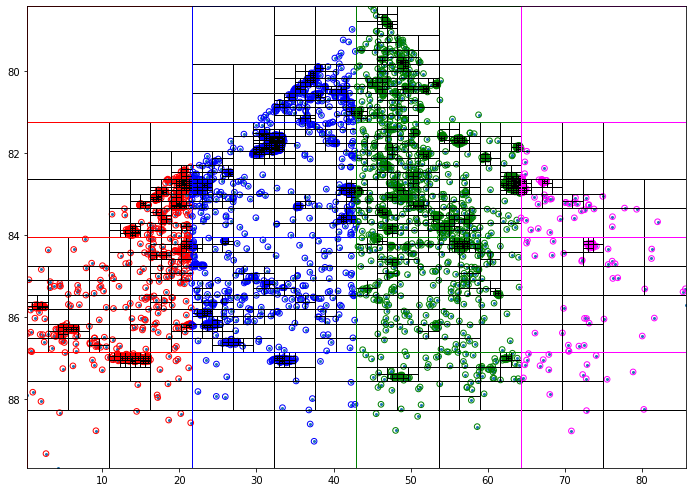

In [9]:
DPI = 72
fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
ax = plt.subplot()
ax.set_xlim(minRA, maxRA)
ax.set_ylim(minDEC, maxDEC)
qtree.draw(ax)
ax.scatter([p.x for p in dataConv], [p.y for p in dataConv], s=4)
#ax.set_xticks([])
#ax.set_yticks([])
fc=["red","blue","green","magenta",\
    "red","blue","green","magenta",\
    "red","blue","green","magenta",\
    "red","blue","green","magenta"]
for ii,nn in enumerate(region_pts):
    ax.scatter([p.x for p in nn],[p.y for p in nn],facecolors='none',\
               edgecolors=fc[ii], s=32)
    regions[ii].draw(ax, c=fc[ii])

ax.invert_yaxis()
plt.tight_layout()
#plt.savefig('search-quadtree.png', DPI=72)
plt.show()

In [10]:
regionPts=[[[p.x,p.y,p.payload] for p in nn] for nn in region_pts]
regionPtsTr=[]
for ii,nn in enumerate(regionPts):
    regionPtsTr.append(np.transpose(nn))

In [11]:
# parms to run 3pcf
nrbin=30 #bins r
nmubin=30 #bins mu
nthtbin=nmubin
nskip=1 #step in pts
rmin= 1.
rmax= 15.
rArr=np.arange(rmin,rmax,(rmax-rmin)/nrbin)
muArr=np.arange(-1,1,2./nmubin)
Nchunks=10 #threads per job

In [21]:
t1=time.perf_counter()
kkk_patches=[]
for nn in regionPts[1:2]:
    tn1=time.perf_counter()
    jobs=[]
    params=get_params(Nchunks,nn)
    #rint(*params)
    for ii in params:
        jobs.append(Executor(max_workers=2).submit(KKK,ii[0],ii[1],nskip,nn,\
                   rmin,rmax,nrbin,nmubin,'mu'))
    results=[]
    for ii in jobs:
        results.append(ii.result())
    hist=np.zeros((nrbin,nrbin,nthtbin))
    for ii in results:
        hist+=np.array(ii)
    kkk_patches.append(hist)
    tn2=time.perf_counter()
    print("patch time:%7.2f"%(tn2-tn1))
t2=time.perf_counter()
print("time:%7.2f"%(t2-t1))

patch time:  89.27
time:  89.27


In [13]:
#np.save("/home/joar/temporal/NPCF_data/BruteForce/v1.2_r1-15_p5-6",kkk_patches[:2])
kkk_patches=np.load("/home/joar/temporal/NPCF_data/BruteForce/v1.2_r1-15_p5-6.npy")

In [14]:
len(kkk_patches)

2

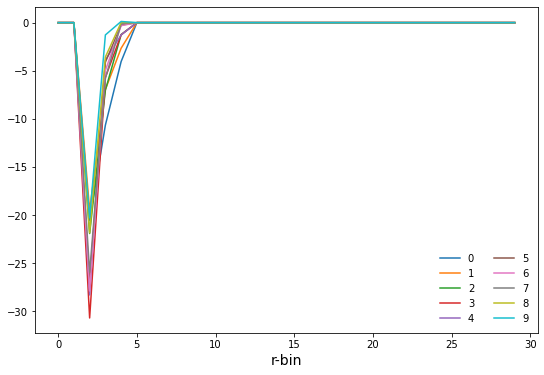

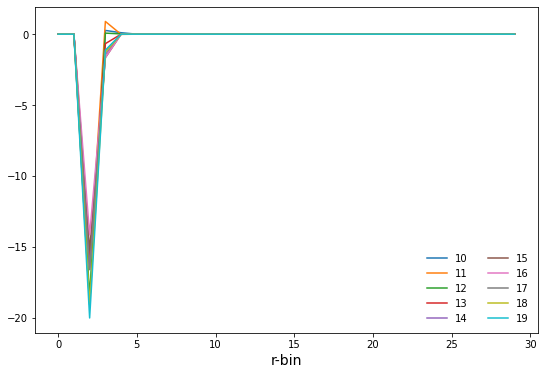

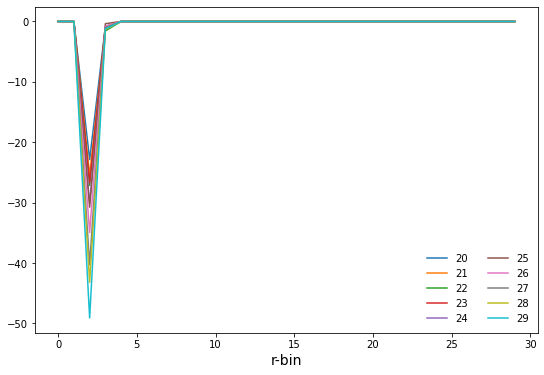

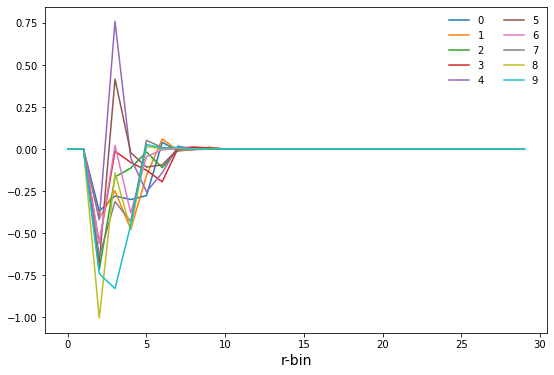

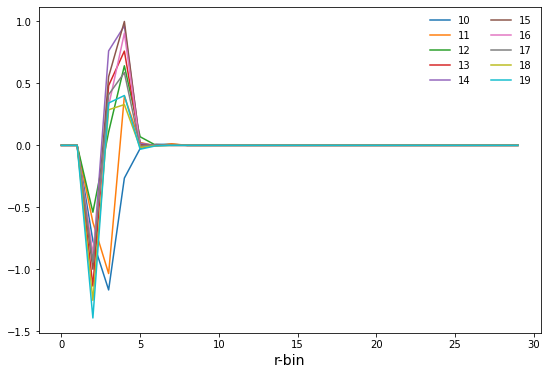

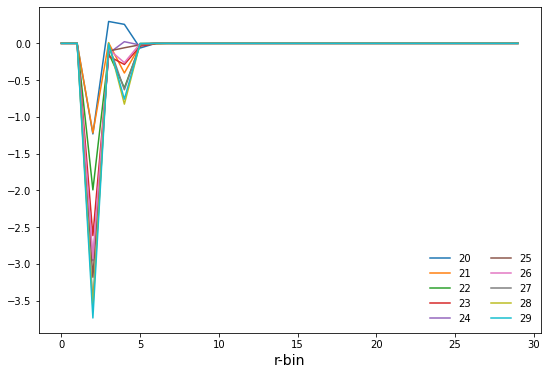

In [15]:
for nn in range(len(kkk_patches)):   
    plt.figure(figsize=(9,6))
    for ii in range(10):
        plt.plot(np.diagonal(kkk_patches[nn][:,:,ii]/np.max(kkk_patches[nn])),label="%d"%(ii))
    plt.legend(frameon=False,ncol=2)
    plt.xlabel("r-bin",fontsize=14)
    plt.show()
    plt.figure(figsize=(9,6))
    for ii in range(10,20):
        plt.plot(np.diagonal(kkk_patches[nn][:,:,ii]/np.max(kkk_patches[nn])),label="%d"%(ii))
    plt.legend(frameon=False,ncol=2)
    plt.xlabel("r-bin",fontsize=14)
    plt.show()
    plt.figure(figsize=(9,6))
    for ii in range(20,30):
        plt.plot(np.diagonal(kkk_patches[nn][:,:,ii]/np.max(kkk_patches[nn])),label="%d"%(ii))
    plt.legend(frameon=False,ncol=2)
    plt.xlabel("r-bin",fontsize=14)
    
    #plt.savefig("KKK_rrtht.jpg",DPI=DPI)
    plt.show()

scaleplot=10**(-15)
ax.
plt.figure(figsize=(13,11))
plt.imshow(kkk_patches[0][:,:,20],origin='lower',cmap=cmap,\
    interpolation='bilinear', norm=norm, vmin=-scaleplot,\
    vmax=scaleplot)
plt.colorbar()
plt.ylabel('r2-bin')
plt.xlabel('r1-bin')
plt.show()

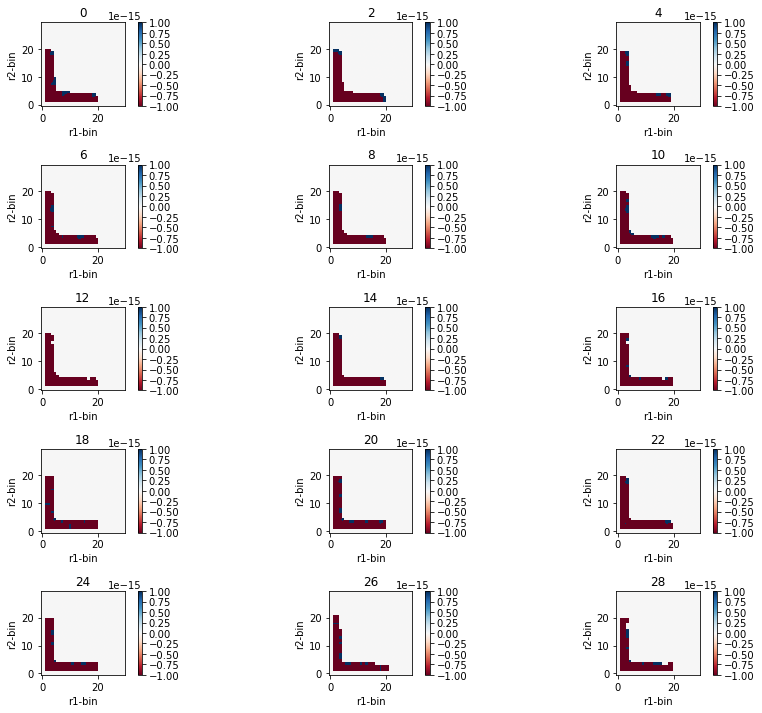

In [24]:
fig=plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.7,wspace=.1)
#plt.suptitle("Daily closing prices", fontsize=18, y=0.95)
stepbtwn=2
scaleplot=1*10**(-15)
# loop through the length of tickers and keep track of index
for mu in range(len(np.array(kkk_patches)[0,0,:][::stepbtwn])):
    # add a new subplot iteratively
    ax = fig.add_subplot(5, 3, mu + 1)
    plt.imshow(kkk_patches[0][:,:,mu],origin='lower',cmap=cmap,\
    interpolation='bilinear', norm=norm, vmin=-scaleplot,\
    vmax=scaleplot)
    plt.title(mu*stepbtwn)
    plt.colorbar()
    plt.ylabel('r2-bin')
    plt.xlabel('r1-bin')
plt.show()

In [27]:
len(np.array(kkk_patches)[0,0,:][::2])

15

##  let's doblecheck "estimator" for randoms

In [27]:
randoms=[]
rands=np.reshape(np.random.uniform(0,10*np.sqrt(2),100),(50,2))
for ii in range(len(rands)):
    randoms.append([rands[ii][0],rands[ii][1],-1])

In [29]:
tn1=time.perf_counter()
jobs=[]
params=get_params(Nchunks,randoms)
for ii in params:
    jobs.append(Executor(max_workers=2).submit(KKK,ii[0],ii[1],nskip,randoms,\
               rmin,rmax,nrbin,nmubin,'mu'))
results=[]
for ii in jobs:
    results.append(ii.result())
hist=np.zeros((nrbin,nrbin,nthtbin))
for ii in results:
    hist+=np.array(ii)
tn2=time.perf_counter()
print("patch time:%7.2f"%(tn2-tn1))

patch time:   0.89


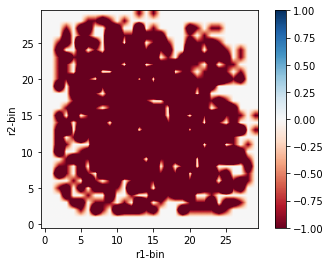

In [33]:
scaleplot=1
plt.imshow(hist[:,:,20],origin='lower',cmap=cmap,\
    interpolation='bilinear', norm=norm, vmin=-scaleplot,\
    vmax=scaleplot)
plt.colorbar()
plt.ylabel('r2-bin')
plt.xlabel('r1-bin')
plt.show()

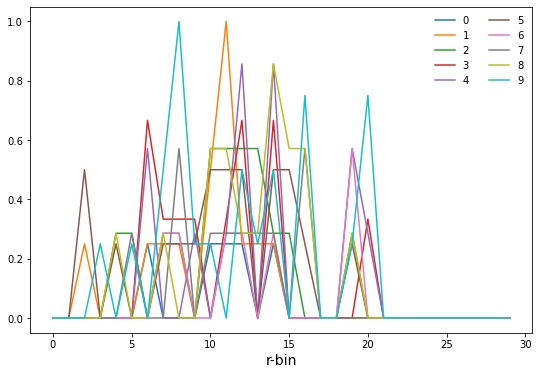

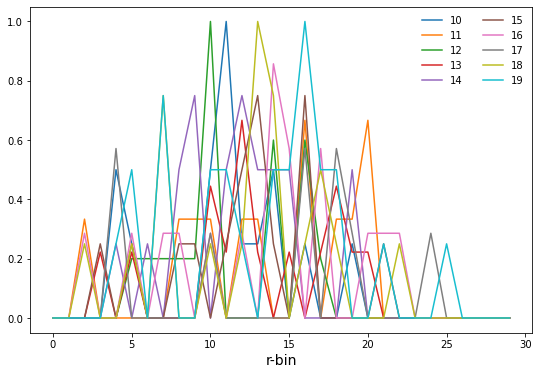

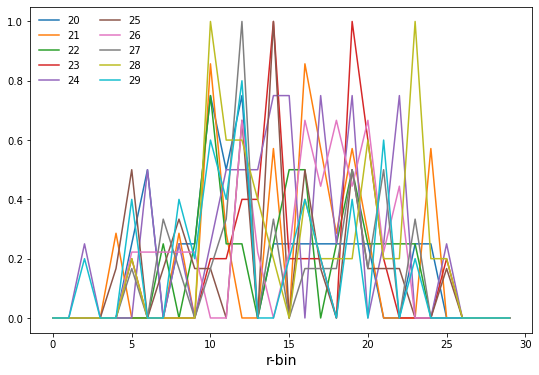

In [38]:
plt.figure(figsize=(9,6))
for ii in range(10):
    plt.plot(np.diagonal(hist[:,:,ii]/np.min(hist[:,:,ii])),label="%d"%(ii))
plt.legend(frameon=False,ncol=2)
plt.xlabel("r-bin",fontsize=14)
plt.show()
plt.figure(figsize=(9,6))
for ii in range(10,20):
    plt.plot(np.diagonal(hist[:,:,ii]/np.min(hist[:,:,ii])),label="%d"%(ii))
plt.legend(frameon=False,ncol=2)
plt.xlabel("r-bin",fontsize=14)
plt.show()
plt.figure(figsize=(9,6))
for ii in range(20,30):
    plt.plot(np.diagonal(hist[:,:,ii]/np.min(hist[:,:,ii])),label="%d"%(ii))
plt.legend(frameon=False,ncol=2)
plt.xlabel("r-bin",fontsize=14)

#plt.savefig("KKK_rrtht.jpg",DPI=DPI)
plt.show()